# Preparation of raw (binary) data

Raw data comes in many forms, often binary. Working with it is straightforward, but requires a certain degree of care to ensure that the data that we read in fact contains the information we expect.

__Contents:__
- <a href="#overview">Overview of the data set</a>
- <a href="#input_check">Examining the input patterns</a>
- <a href="#label_check">Examining the instance labels</a>
- <a href="#finalprep">Final preparation of the data</a>
___

<a id="overview"></a>
## Overview of the data set

As a straightforward exercise in manipulating binary files using standard Python functions, here we shall make use of the the well-known database of handwritten digits, called MNIST, a __m__odified subset of a larger dataset from the __N__ational __I__nstitute of __S__tandards and __T__echnology.

<img src="img/ex_MNIST.png" alt="Stimuli Image" />

A typical source for this data set is the website of Y. LeCun (http://yann.lecun.com/exdb/mnist/). They provide the following description,

> *"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image"*

and the following files containing the data of interest.

> train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
> train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
> t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
> t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

The files are stored in a binary format called __IDX__, typically used for storing vector data. First we decompress the files via

```
$ cd data/MNIST
$ gunzip train-images-idx3-ubyte.gz
$ gunzip train-labels-idx1-ubyte.gz
$ gunzip t10k-images-idx3-ubyte.gz
$ gunzip t10k-labels-idx1-ubyte.gz
```
which leaves us with the desired binary files.

___

<a id="input_check"></a>
## Examining the input patterns

Let us begin by opening a file connection with the training examples.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

toread = "data/MNIST/train-images-idx3-ubyte"

f_bin = open(toread, mode="rb")

print(f_bin)


<_io.BufferedReader name='data/MNIST/train-images-idx3-ubyte'>


Now, in order to ensure that we are reading the data correctly, the only way to confirm this is by inspecting and checking with what the authors of the data file tell us *should* be there. From the page of LeCun et al. linked above, we have the following:

```
TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```

The "offset" here refers to the number of bytes read from the start of the file. An offset of zero refers to the first byte, and an offset of 0004 refers to the fifth byte, 0008 the ninth byte, and so forth. Let's check that we are able to successfully read what we expect.

In [2]:
print("First four bytes:") # should be magic number, 2051.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))

First four bytes:
bytes:  b'\x00\x00\x08\x03'
 int:  2051


Note that the byte data `b'\x00\x00\x08\x03'` shown here by Python is a hexadecimal representation of the first four bytes. This corresponds directly to the "value" in the first row of the table above, ``0x00000803``. The ``\x`` breaks simply show where one byte starts and another ends, recalling that using two hexadecimal digits we can represent the integers from $0, 1, 2, \ldots$ through to $(15 \times 16^{1} + 15 \times 16^{0}) = 255$, just as we can with 8 binary digits, or 8 *bits*. Anyways, converting this to decimal, $3 \times 16^{0} + 8 \times 16^{2} = 2051$, precisely what we expect.

Using the *read* method, let us read four bytes at a time to ensure the remaining data is read correctly.

In [3]:

print("Second four bytes:") # should be number of imgs = 60000
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Second four bytes:
bytes:  b'\x00\x00\xea`'
 int:  60000


In [4]:

print("Third four bytes:") # should be number of rows = 28
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Third four bytes:
bytes:  b'\x00\x00\x00\x1c'
 int:  28


In [5]:

print("Fourth four bytes:") # should be number of cols = 28
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Fourth four bytes:
bytes:  b'\x00\x00\x00\x1c'
 int:  28


Things seem to be as they should be. We have been able to accurately extract all the information necessary to read out all the remaining data stored in this file. Since these happen to be images, the accuracy of our read-out can be easily assessed by looking at the image content.

In [6]:

n = 60000 # (anticipated) number of images.
d = 28*28 # number of entries (int values) per image.
times_todo = 5 # number of images to view.
bytes_left = d
data_x = np.zeros((d,), dtype=np.uint8) # initialize.


Note that we are using the `uint8` (unsigned 1-byte int) data type, because we know that the values range between 0 and 255, based on the description by the authors of the data set, which says

> "Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black)."

More concretely, we have that the remaining elements of the data set are of the form
```
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```
and so to read out one pixel value at a time (values between 0 and 255), we must read one byte at a time (rather than four bytes as we had just been doing). There should be $28 \times 28 = 784$ pixels per image.

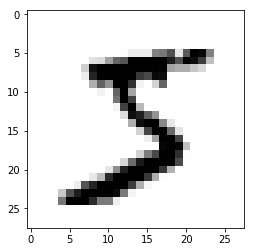

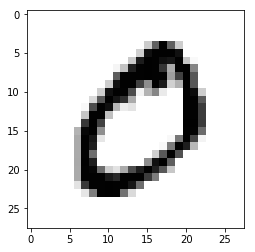

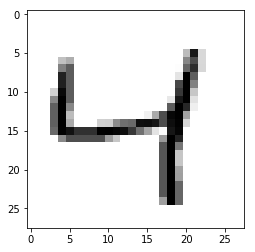

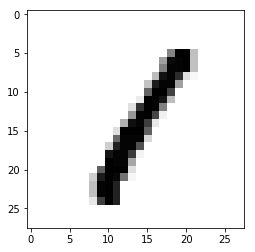

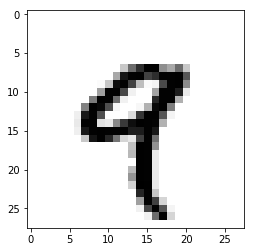

Successfully closed.


In [7]:
for t in range(times_todo):

    idx = 0
    while idx < bytes_left:
        # Iterate one byte at a time.
        b = f_bin.read(1)
        data_x[idx] = int.from_bytes(b, byteorder="big", signed=False)
        idx += 1

    img_x = data_x.reshape( (28,28) ) # populate one row at a time.
    
    # binary colour map highlights foreground (black) against background(white)
    plt.imshow(img_x, cmap=plt.cm.binary)
    #plt.savefig(("MNIST_train_"+str(t)+".png"))
    plt.show()


f_bin.close()
if f_bin.closed:
    print("Successfully closed.")

### Exercises (A):

0. When using the `from_bytes` method of `int`, change `signed` from `False` to `True`. Does the result of the binary to integer conversion change? If so, how? (provide examples) If possible, explain what causes this difference.

0. Similarly, change `byteorder` from `"big"` to `"little"`, and investigate if and how things change. Check `help(int.from_bytes)` for more information.

0. Note that there are countless colour maps (https://matplotlib.org/users/colormaps.html) available. Instead of `binary` as used, above try `gray`, `bone`, `pink`, and any others that catch your interest.

0. Uncomment the `savefig` line above, and save the first 10 training images to file. Then do the exact same procedure for *test* images, changing the file names appropriately.

___

<a id="label_check"></a>
## Examining the labels

The images, or more generally, the *instances* to be used for the classification task appear as we expect. Let us now shift our focus over to the corresponding *labels* and confirm that the first `times_todo` instances indeed have the labels that we expect. These are stored in the `train-labels-idx1-ubyte` file.

In [8]:
toread = "data/MNIST/train-labels-idx1-ubyte"

f_bin = open(toread, mode="rb")

print(f_bin)

<_io.BufferedReader name='data/MNIST/train-labels-idx1-ubyte'>


Once again from the page of LeCun et al. linked above, we have for labels that the contents should be as follows.

```
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
```

Let's inspect the first eight bytes.

In [9]:
print("First four bytes:") # should be magic number, 2049.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big"))

First four bytes:
bytes:  b'\x00\x00\x08\x01'
 int:  2049


In [10]:

print("Second four bytes:") # should be number of observations, 60000.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big"))


Second four bytes:
bytes:  b'\x00\x00\xea`'
 int:  60000


From here should be labels from 0 to 9. Let's confirm that the patterns above have correct labels corresponding to them in the place that we expect:

In [11]:

for t in range(times_todo):

    b = f_bin.read(1)
    mylabel = int.from_bytes(b, byteorder="big", signed=False)
    
    print("Label =", mylabel)
    

Label = 5
Label = 0
Label = 4
Label = 1
Label = 9


### Exercises (B):

0. Print out the label values for the first 10 images in both the training and testing data sets. Do these match the numbers that appear to be written in the images you saved to disk previously? (they should)

0. (Bonus) Instead of using `read`, we can use `seek` to jump to an arbitrary byte offset. In the example of instance labels above, `f_bin.seek(0)` would take us to the start of the file, and `f_bin.seek(8)` takes us to the point where the first label value is saved (since the first 8 bytes are clerical information). With this in mind, write a function that uses `seek` to display the label of the $k$th image, given integer $k$ only.

0. (Bonus) Similarly, write a function which uses `seek` to read and display the $k$th image itself, given just integer $k$.
___

<a id="finalprep"></a>
## Final preparation of the data

While our examination of the data thus far has not been completely rigorous (i.e., there are many image-label pairs we have not checked), the above analysis provides a good introduction to the kind of information we are dealing with in this (and similar) tasks, and the format in which that information is stored.

Now, as an important practical concern, we will not want to have to open up the file and read pixel values byte-by-byte in the above fashion every time we want to train a classifier. A more reasonable approach is to read out each of the full data sets just once, and then re-write them to disk as a Python-format binary file, which is much faster to read on-the-fly, assuming the machine doing the *writing* is also the machine doing the *reading*.

Let us start by reading the whole file.

In [12]:
toread = "data/MNIST/train-images-idx3-ubyte"
n = 60000
d = 28*28
bytes_left = n * d
data_X = np.empty((n*d,), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(16) # go to start of images.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_X[idx] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")


Reading binary file... Done reading... OK, file closed.


Using the unsigned integer `uint8` data type, we have assembled all pixel values for all instances in one long vector. Let's examine basic statistics.

In [13]:
print("Min:", np.min(data_X))
print("Mean:", np.mean(data_X))
print("Median:", np.median(data_X))
print("Max:", np.max(data_X))
print("StdDev:", np.std(data_X))

print(np.bincount(data_X))


Min: 0
Mean: 33.318421449829934
Median: 0.0
Max: 255
StdDev: 78.56748998339798
[38045844    22896    33653    36040    38267    39148    37692    38856
    30878    38234    35282    36020    30139    40100    26939    28869
    29115    27551    26849    34431    29955    35496    26750    22910
    25950    29995    24260    24025    25434    37160    22913    26205
    28890    15556    19906    21516    22128    24760    25922    18250
    20675    27023    22349    21227    19030    21122    17326    24237
    20083    17919    23964    25003    14588    19230    18195    18068
    23511    31905    14330    18140    18144    18133    19805    23909
    46754    16050    17514    15914    16302    16742    19288    18444
    17313    19307    13816    15875    17877    13535    17569    18085
    15872    16527    21112    15514    27088    25496    25837    12645
    15796    17628    12695    17876    18525    17225    16655    16244
    17902    14246    16820    17710    15217

Certain models run into numerical difficulties if the input features are too large. Here they range over $\{0,1,\ldots,255\}$, which can lead to huge values when, for example, passed through exponential functions (e.g., logistic regression model).

To get around this, it is useful to map the values to the unit interval $[0,1]$. The basic formula is simple: (VALUE - MIN) / (MAX - MIN). We will use more memory to store floating point numbers, but computation in learning tasks is often made considerably easier.

In [14]:
data_X_float = np.empty(data_X.shape, dtype=np.float32)
data_X_float = np.float32((data_X - np.min(data_X))/(np.max(data_X) - np.min(data_X)))

In [15]:
print("Min:", np.min(data_X_float))
print("Mean:", np.mean(data_X_float))
print("Median:", np.median(data_X_float))
print("Max:", np.max(data_X_float))
print("StdDev:", np.std(data_X_float))

Min: 0.0
Mean: 0.13066062
Median: 0.0
Max: 1.0
StdDev: 0.30810776


All that remains now is to re-write to disk using the handy `tofile` function from `numpy`, as follows. The important point here is to ensure that we know the `dtype` used when writing, so that we can correctly read the data using the companion function `fromfile`.

In [16]:

print("Writing binary file...", end=" ")
towrite = "data/MNIST/X_tr.dat"
with open(towrite, mode="bw") as g_bin:
    data_X_float.tofile(g_bin) # don't forget the dtype used.
print("OK.")


Writing binary file... OK.


Now, try reading this file, and compare with the original data. There should be no errors in reconstruction, and clearly reading from the Python-format binary file is *much* faster than reading from the IDX file one byte at a time.

In [17]:
with open(towrite, mode="br") as g_bin:
    data_X_check = np.fromfile(g_bin, dtype=np.float32)
print("OK.")

print("Shapes:", data_X_check.shape, data_X_float.shape)
print("Difference =", np.linalg.norm(data_X_check-data_X_float))

OK.
Shapes: (47040000,) (47040000,)
Difference = 0.0


___

Let us do the same thing for label data. Instead of `X`, corresponding to input patterns, we call the labels `y`.

In [18]:
toread = "data/MNIST/train-labels-idx1-ubyte"
n = 60000
bytes_left = n
data_y = np.empty((n,), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(8) # go to start of the labels.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_y[idx] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")


Reading binary file... Done reading... OK, file closed.


As before, we use the unsigned integer `uint8` data type, and assemble all the labels for the training data. Let's examine basic statistics.

Min: 0
Mean: 4.4539333333333335
Median: 4.0
Max: 9
StdDev: 2.889246360020012
Bin counts:
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


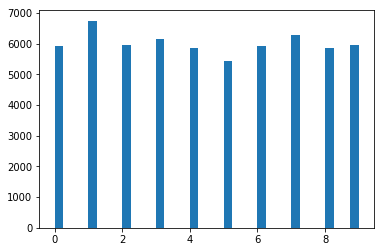

In [19]:
print("Min:", np.min(data_y))
print("Mean:", np.mean(data_y))
print("Median:", np.median(data_y))
print("Max:", np.max(data_y))
print("StdDev:", np.std(data_y))

print("Bin counts:")
print(np.bincount(data_y))

plt.hist(np.hstack(data_y), bins='auto')
plt.show()


Once again, let's repeat the process of writing and double-checking the data.

In [20]:
print("Writing binary file...", end=" ")
towrite = "data/MNIST/y_tr.dat"
with open(towrite, mode="bw") as g_bin:
    data_y.tofile(g_bin) # don't forget the dtype used.
print("OK.")

Writing binary file... OK.


In [21]:
with open(towrite, mode="br") as g_bin:
    data_y_check = np.fromfile(g_bin, dtype=np.uint8)
print("OK.")

print("Shapes:", data_y_check.shape, data_y.shape)
print("Difference =", np.linalg.norm(data_y_check-data_y))

OK.
Shapes: (60000,) (60000,)
Difference = 0.0


### Exercises (C):

0. Repeat the above process for the testing data. We used `X_tr` and `y_tr` for naming the __tr__aining data; use `X_te` and `y_te` for naming the __te__sting data, saving each of their respective `.dat` files to the directory shown above.

0. Save the histograms for both the training and test labels. Are the data sets "balanced" in terms of the labels present? Which digit is most common? Least common? Do these change between the training and test data sets?

0. (Bonus) It is often convenient to "centre" and "standardize" data observations to have zero (empirical) mean and unit (empirical) variance. Use the `reshape` method to transform the long `data_X_float` vector into a matrix (a numpy array with two axes) of the form $n \times d$, where $n$ is the number of samples, and $d$ is the number of pixels per image. Compute the per-column means and standard deviations, and subtract/divide as necessary.
___